# Thuật toán ABC



In [ ]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Callable, List, Tuple, Optional, Dict, Any
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
@dataclass
class ABCResult:
    best_position: np.ndarray
    best_value: float               # giá trị f(x) tốt nhất (theo minimize/maximize gốc)
    history_best: List[float]       # best theo từng cycle
    n_evals: int                    # số lần gọi hàm mục tiêu

In [ ]:
def artificial_bee_colony(
    func: Callable[[np.ndarray], float],
    bounds: List[Tuple[float, float]],
    colony_size: int = 40,
    max_cycles: int = 500,
    limit: int = 100,
    minimize: bool = True,
    seed: Optional[int] = None,
    return_history: bool = True,
):
    rng = np.random.default_rng(seed)

    D = len(bounds)
    bounds_arr = np.array(bounds, dtype=float)
    lower = bounds_arr[:, 0]
    upper = bounds_arr[:, 1]

    if colony_size % 2 != 0:
        raise ValueError("colony_size phải là số chẵn để chia đôi employed/onlooker.")

    n_sources = colony_size // 2

    def random_food_sources(n: int) -> np.ndarray:
        """Sinh ngẫu nhiên n nghiệm trong miền bounds."""
        return lower + rng.random((n, D)) * (upper - lower)

    def clip_to_bounds(x: np.ndarray) -> np.ndarray:
        """Cắt nghiệm về trong miền."""
        return np.minimum(np.maximum(x, lower), upper)

    # Fitness dựa trên công thức trong bài báo
    def objective_value(x: np.ndarray) -> float:
        val = func(x)
        return val if minimize else -val

    def fitness_from_obj(obj: float) -> float:
        # obj là f(x) theo công thức
        if obj >= 0:
            return 1.0 / (1.0 + obj)
        else:
            return 1.0 + abs(obj)

    # Khởi tạo
    foods = random_food_sources(n_sources)
    obj_vals = np.array([objective_value(x) for x in foods])
    n_evals = n_sources

    fitness = np.array([fitness_from_obj(v) for v in obj_vals])
    trials = np.zeros(n_sources, dtype=int)

    # Best theo objective_value (minimize)
    best_idx = np.argmin(obj_vals)
    best_pos = foods[best_idx].copy()
    best_obj = obj_vals[best_idx]
    history_best = [best_obj] if return_history else []

    # Main loop
    for cycle in range(1, max_cycles + 1):

        # Pha Employed Bees
        for i in range(n_sources):
            # chọn k != i
            k = i
            while k == i:
                k = rng.integers(0, n_sources)

            # chọn chiều j
            j = rng.integers(0, D)

            phi = rng.uniform(-1.0, 1.0)

            candidate = foods[i].copy()
            candidate[j] = foods[i, j] + phi * (foods[i, j] - foods[k, j])
            candidate = clip_to_bounds(candidate)

            cand_obj = objective_value(candidate)
            n_evals += 1
            cand_fit = fitness_from_obj(cand_obj)

            # greedy selection (minimize obj)
            if cand_obj < obj_vals[i]:
                foods[i] = candidate
                obj_vals[i] = cand_obj
                fitness[i] = cand_fit
                trials[i] = 0
            else:
                trials[i] += 1

        # Pha Onlooker Bees
        fit_sum = np.sum(fitness)
        if fit_sum == 0:
            probs = np.ones(n_sources) / n_sources
        else:
            probs = fitness / fit_sum

        for _ in range(n_sources):  # số onlooker = số sources
            i = rng.choice(n_sources, p=probs)

            k = i
            while k == i:
                k = rng.integers(0, n_sources)

            j = rng.integers(0, D)
            phi = rng.uniform(-1.0, 1.0)

            candidate = foods[i].copy()
            candidate[j] = foods[i, j] + phi * (foods[i, j] - foods[k, j])
            candidate = clip_to_bounds(candidate)

            cand_obj = objective_value(candidate)
            n_evals += 1
            cand_fit = fitness_from_obj(cand_obj)

            if cand_obj < obj_vals[i]:
                foods[i] = candidate
                obj_vals[i] = cand_obj
                fitness[i] = cand_fit
                trials[i] = 0
            else:
                trials[i] += 1

        # Pha Scout Bees
        for i in range(n_sources):
            if trials[i] >= limit:
                foods[i] = random_food_sources(1)[0]
                obj_vals[i] = objective_value(foods[i])
                n_evals += 1
                fitness[i] = fitness_from_obj(obj_vals[i])
                trials[i] = 0

        # Cập nhật best
        cur_best_idx = np.argmin(obj_vals)
        if obj_vals[cur_best_idx] < best_obj:
            best_obj = obj_vals[cur_best_idx]
            best_pos = foods[cur_best_idx].copy()

        if return_history:
            history_best.append(best_obj)

    # đổi best_obj về giá trị gốc f(x)
    best_value = best_obj if minimize else -best_obj

    return ABCResult(
        best_position=best_pos,
        best_value=best_value,
        history_best=history_best,
        n_evals=n_evals
    )

In [ ]:
import numpy as np
from dataclasses import dataclass
from typing import Callable, List, Tuple, Optional

@dataclass
class ABCResult:
    best_value: float
    best_position: np.ndarray
    n_evals: int
    history_best: List[float]

def _clip_to_bounds(x: np.ndarray, bounds: List[Tuple[float, float]]) -> np.ndarray:
    lo = np.array([b[0] for b in bounds], dtype=float)
    hi = np.array([b[1] for b in bounds], dtype=float)
    return np.minimum(np.maximum(x, lo), hi)

def _wrap_to_bounds(x: np.ndarray, bounds: List[Tuple[float, float]]) -> np.ndarray:
    # chỉ dùng khi biến là góc/chu kỳ (vd: [0, 2pi))
    lo = np.array([b[0] for b in bounds], dtype=float)
    hi = np.array([b[1] for b in bounds], dtype=float)
    return np.mod(x - lo, (hi - lo)) + lo

def _fitness(cost: float, minimize: bool) -> float:
    # fitness càng lớn càng tốt
    if minimize:
        return 1.0 / (1.0 + cost)
    else:
        # maximize => coi "cost" là giá trị cần maximize
        return 1.0 + cost if cost >= 0 else 1.0 / (1.0 + abs(cost))

def artificial_bee_colony(
    func: Callable[[np.ndarray], float],
    bounds: List[Tuple[float, float]],
    colony_size: int = 40,
    max_cycles: int = 500,
    limit: int = 50,
    minimize: bool = True,
    seed: int = 0,
    wrap: bool = False,     # False cho bài test [-5,5]; True cho JCAS [0,2pi)
) -> ABCResult:
    rng = np.random.default_rng(seed)
    dim = len(bounds)

    project = _wrap_to_bounds if wrap else _clip_to_bounds

    X = np.array([rng.uniform(b[0], b[1], size=dim) for b in [bounds[0]]*colony_size], dtype=float)
    # dòng trên hơi trick; thay bằng init chuẩn:
    X = np.vstack([rng.uniform([b[0] for b in bounds], [b[1] for b in bounds]) for _ in range(colony_size)])

    n_evals = 0
    f = np.array([func(x) for x in X], dtype=float); n_evals += colony_size
    trial = np.zeros(colony_size, dtype=int)

    best_idx = int(np.argmin(f) if minimize else np.argmax(f))
    best_x = X[best_idx].copy()
    best_val = float(f[best_idx])
    history = [best_val]

    for _ in range(max_cycles):
        # --- Employed bees
        for i in range(colony_size):
            k = rng.integers(0, colony_size - 1)
            if k >= i: k += 1
            j = rng.integers(0, dim)
            phi = rng.uniform(-1.0, 1.0)

            V = X[i].copy()
            V[j] = X[i, j] + phi * (X[i, j] - X[k, j])
            V = project(V, bounds)

            fv = func(V); n_evals += 1
            better = (fv < f[i]) if minimize else (fv > f[i])
            if better:
                X[i], f[i] = V, fv
                trial[i] = 0
            else:
                trial[i] += 1

        # --- Onlooker bees
        fits = np.array([_fitness(ci, minimize) for ci in f], dtype=float)
        probs = fits / (fits.sum() + 1e-12)

        for _ in range(colony_size):
            i = rng.choice(colony_size, p=probs)
            k = rng.integers(0, colony_size - 1)
            if k >= i: k += 1
            j = rng.integers(0, dim)
            phi = rng.uniform(-1.0, 1.0)

            V = X[i].copy()
            V[j] = X[i, j] + phi * (X[i, j] - X[k, j])
            V = project(V, bounds)

            fv = func(V); n_evals += 1
            better = (fv < f[i]) if minimize else (fv > f[i])
            if better:
                X[i], f[i] = V, fv
                trial[i] = 0
            else:
                trial[i] += 1

        # --- Scout bees
        for i in range(colony_size):
            if trial[i] > limit:
                X[i] = rng.uniform([b[0] for b in bounds], [b[1] for b in bounds])
                X[i] = project(X[i], bounds)
                f[i] = func(X[i]); n_evals += 1
                trial[i] = 0

        best_idx = int(np.argmin(f) if minimize else np.argmax(f))
        if (minimize and f[best_idx] < best_val) or ((not minimize) and f[best_idx] > best_val):
            best_val = float(f[best_idx])
            best_x = X[best_idx].copy()

        history.append(best_val)

    return ABCResult(best_value=best_val, best_position=best_x, n_evals=n_evals, history_best=history)

def generalized_bee_colony(
    func: Callable[[np.ndarray], float],
    bounds: List[Tuple[float, float]],
    colony_size: int = 40,
    max_cycles: int = 500,
    limit: int = 50,
    minimize: bool = True,
    seed: int = 0,
    wrap: bool = False,
    psi_max: float = 1.0
) -> ABCResult:
    # GABC = ABC + term kéo về global best
    rng = np.random.default_rng(seed)
    dim = len(bounds)
    project = _wrap_to_bounds if wrap else _clip_to_bounds

    X = np.vstack([rng.uniform([b[0] for b in bounds], [b[1] for b in bounds]) for _ in range(colony_size)])
    n_evals = 0
    f = np.array([func(x) for x in X], dtype=float); n_evals += colony_size
    trial = np.zeros(colony_size, dtype=int)

    best_idx = int(np.argmin(f) if minimize else np.argmax(f))
    gbest = X[best_idx].copy()
    gbest_val = float(f[best_idx])
    history = [gbest_val]

    for _ in range(max_cycles):
        # --- Employed
        for i in range(colony_size):
            k = rng.integers(0, colony_size - 1)
            if k >= i: k += 1
            j = rng.integers(0, dim)
            phi = rng.uniform(-1.0, 1.0)
            psi = rng.uniform(0.0, psi_max)

            V = X[i].copy()
            V[j] = X[i, j] + phi * (X[i, j] - X[k, j]) + psi * (gbest[j] - X[i, j])
            V = project(V, bounds)

            fv = func(V); n_evals += 1
            better = (fv < f[i]) if minimize else (fv > f[i])
            if better:
                X[i], f[i] = V, fv
                trial[i] = 0
            else:
                trial[i] += 1

        # update global best
        best_idx = int(np.argmin(f) if minimize else np.argmax(f))
        if (minimize and f[best_idx] < gbest_val) or ((not minimize) and f[best_idx] > gbest_val):
            gbest_val = float(f[best_idx])
            gbest = X[best_idx].copy()

        # --- Onlooker
        fits = np.array([_fitness(ci, minimize) for ci in f], dtype=float)
        probs = fits / (fits.sum() + 1e-12)

        for _ in range(colony_size):
            i = rng.choice(colony_size, p=probs)
            k = rng.integers(0, colony_size - 1)
            if k >= i: k += 1
            j = rng.integers(0, dim)
            phi = rng.uniform(-1.0, 1.0)
            psi = rng.uniform(0.0, psi_max)

            V = X[i].copy()
            V[j] = X[i, j] + phi * (X[i, j] - X[k, j]) + psi * (gbest[j] - X[i, j])
            V = project(V, bounds)

            fv = func(V); n_evals += 1
            better = (fv < f[i]) if minimize else (fv > f[i])
            if better:
                X[i], f[i] = V, fv
                trial[i] = 0
            else:
                trial[i] += 1

        # --- Scout
        for i in range(colony_size):
            if trial[i] > limit:
                X[i] = rng.uniform([b[0] for b in bounds], [b[1] for b in bounds])
                X[i] = project(X[i], bounds)
                f[i] = func(X[i]); n_evals += 1
                trial[i] = 0

        # update global best + history
        best_idx = int(np.argmin(f) if minimize else np.argmax(f))
        if (minimize and f[best_idx] < gbest_val) or ((not minimize) and f[best_idx] > gbest_val):
            gbest_val = float(f[best_idx])
            gbest = X[best_idx].copy()

        history.append(gbest_val)

    return ABCResult(best_value=gbest_val, best_position=gbest, n_evals=n_evals, history_best=history)

def quantum_bee_colony(
    func: Callable[[np.ndarray], float],
    bounds: List[Tuple[float, float]],
    colony_size: int = 40,
    max_cycles: int = 500,
    limit: int = 50,
    minimize: bool = True,
    seed: int = 0,
    wrap: bool = False,
    r: float = 1.0
) -> ABCResult:
    # qABC trong report của bạn = Quick ABC (đổi tên cho hợp code vẫn OK)
    rng = np.random.default_rng(seed)
    dim = len(bounds)
    project = _wrap_to_bounds if wrap else _clip_to_bounds

    X = np.vstack([rng.uniform([b[0] for b in bounds], [b[1] for b in bounds]) for _ in range(colony_size)])
    n_evals = 0
    f = np.array([func(x) for x in X], dtype=float); n_evals += colony_size
    trial = np.zeros(colony_size, dtype=int)

    best_idx = int(np.argmin(f) if minimize else np.argmax(f))
    best_x = X[best_idx].copy()
    best_val = float(f[best_idx])
    history = [best_val]

    def dist(a, b):
        return np.linalg.norm(a - b)

    for _ in range(max_cycles):
        # --- Employed (giống ABC chuẩn)
        for i in range(colony_size):
            k = rng.integers(0, colony_size - 1)
            if k >= i: k += 1
            j = rng.integers(0, dim)
            phi = rng.uniform(-1.0, 1.0)

            V = X[i].copy()
            V[j] = X[i, j] + phi * (X[i, j] - X[k, j])
            V = project(V, bounds)

            fv = func(V); n_evals += 1
            better = (fv < f[i]) if minimize else (fv > f[i])
            if better:
                X[i], f[i] = V, fv
                trial[i] = 0
            else:
                trial[i] += 1

        # --- Onlooker (qABC: dùng local-best)
        fits = np.array([_fitness(ci, minimize) for ci in f], dtype=float)
        probs = fits / (fits.sum() + 1e-12)

        for _ in range(colony_size):
            i = rng.choice(colony_size, p=probs)

            # build neighborhood Ni
            dists = np.array([dist(X[i], X[t]) for t in range(colony_size) if t != i], dtype=float)
            md_i = dists.mean() if len(dists) else 0.0

            neighbors = []
            for t in range(colony_size):
                if t == i:
                    continue
                if dist(X[i], X[t]) <= r * md_i:
                    neighbors.append(t)

            # choose local best in neighborhood (include itself)
            candidates = [i] + neighbors
            if minimize:
                best_local_idx = min(candidates, key=lambda t: f[t])
            else:
                best_local_idx = max(candidates, key=lambda t: f[t])

            x_best = X[best_local_idx]

            # generate around x_best (the qABC trick)
            k = rng.integers(0, colony_size - 1)
            if k >= i: k += 1
            j = rng.integers(0, dim)
            phi = rng.uniform(-1.0, 1.0)

            V = x_best.copy()
            V[j] = x_best[j] + phi * (x_best[j] - X[k, j])
            V = project(V, bounds)

            fv = func(V); n_evals += 1
            better = (fv < f[i]) if minimize else (fv > f[i])
            if better:
                X[i], f[i] = V, fv
                trial[i] = 0
            else:
                trial[i] += 1

        # --- Scout
        for i in range(colony_size):
            if trial[i] > limit:
                X[i] = rng.uniform([b[0] for b in bounds], [b[1] for b in bounds])
                X[i] = project(X[i], bounds)
                f[i] = func(X[i]); n_evals += 1
                trial[i] = 0

        best_idx = int(np.argmin(f) if minimize else np.argmax(f))
        if (minimize and f[best_idx] < best_val) or ((not minimize) and f[best_idx] > best_val):
            best_val = float(f[best_idx])
            best_x = X[best_idx].copy()

        history.append(best_val)

    return ABCResult(best_value=best_val, best_position=best_x, n_evals=n_evals, history_best=history)


# Chạy thử
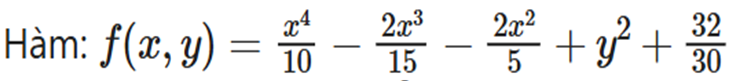!

In [ ]:
# CHẠY THỬ
def test_func(point: np.ndarray) -> float:
    x, y = point[0], point[1]
    return (x**4)/10 - (2*x**3)/15 - (2*x**2)/5 + y**2 + (32/30)


# Miền tìm kiếm của bài toán
bounds = [(-5, 5), (-5, 5)]


# Chạy ABC
result = artificial_bee_colony(
    func=test_func,
    bounds=bounds,
    colony_size=40,
    max_cycles=500,
    limit=50,
    minimize=True,
    seed=42
)

print("Kết quả xấp xỉ tốt nhất:", result.best_value)
print("Vị trí [x, y] tốt nhất:", result.best_position)
print("Số lần lặp:", result.n_evals)
print("Với miền giá trị [x, y] là: ", bounds)

Kết quả xấp xỉ tốt nhất: -2.220446049250313e-16
Vị trí [x, y] tốt nhất: [1.99999999e+00 5.87576395e-09]
Số lần lặp: 40238
Với miền giá trị [x, y] là:  [(-5, 5), (-5, 5)]


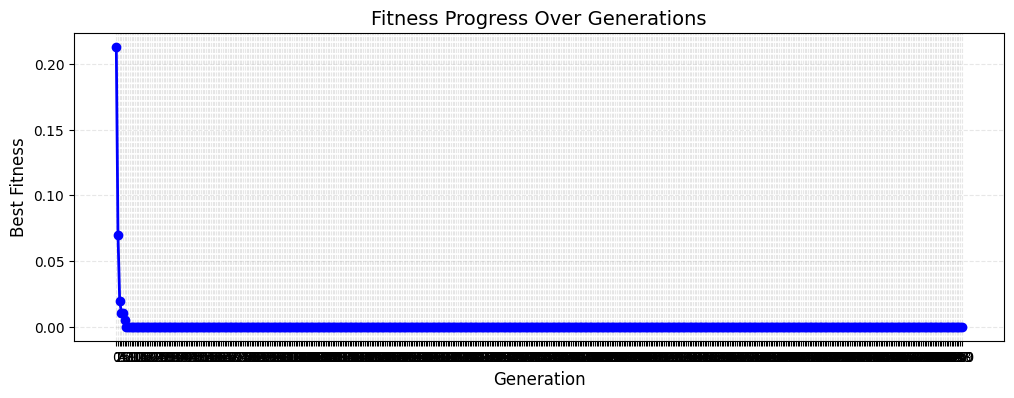

In [ ]:
# FITNESS PLOT


# lấy lịch sử fitness từ ABC
best_history = result.history_best
generations = list(range(len(best_history)))

plt.figure(figsize=(12,4))
plt.plot(generations, best_history, marker='o', color='blue', linestyle='-', linewidth=2)

plt.title("Fitness Progress Over Generations", fontsize=14)
plt.xlabel("Generation", fontsize=12)
plt.ylabel("Best Fitness", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

# Hiển thị
plt.xticks(generations)

plt.show()

# Biến thể của thuật toán ABC

### Thuật toán GABC

In [ ]:
# ===== THUẬT TOÁN GABC (Generalized Artificial Bee Colony) =====
def generalized_bee_colony(
    func: Callable[[np.ndarray], float],
    bounds: List[Tuple[float, float]],
    colony_size: int = 40,
    max_cycles: int = 500,
    limit: int = 100,
    minimize: bool = True,
    seed: Optional[int] = None,
    return_history: bool = True,
) -> ABCResult:
    rng = np.random.default_rng(seed)

    D = len(bounds)
    bounds_arr = np.array(bounds, dtype=float)
    lower = bounds_arr[:, 0]
    upper = bounds_arr[:, 1]

    if colony_size % 2 != 0:
        raise ValueError("colony_size phải là số chẵn để chia đôi employed/onlooker.")

    n_sources = colony_size // 2

    def random_food_sources(n: int) -> np.ndarray:
        """Sinh ngẫu nhiên n nghiệm trong miền bounds."""
        return lower + rng.random((n, D)) * (upper - lower)

    def clip_to_bounds(x: np.ndarray) -> np.ndarray:
        """Cắt nghiệm về trong miền."""
        return np.minimum(np.maximum(x, lower), upper)

    def objective_value(x: np.ndarray) -> float:
        """Hàm mục tiêu, đã xử lý minimize/maximize."""
        val = func(x)
        return val if minimize else -val

    def fitness_from_obj(obj: float) -> float:
        """Chuyển objective value -> fitness (theo bài báo ABC)."""
        if obj >= 0:
            return 1.0 / (1.0 + obj)
        else:
            return 1.0 + abs(obj)

    # Khởi tạo
    foods = random_food_sources(n_sources)
    obj_vals = np.array([objective_value(x) for x in foods])
    n_evals = n_sources

    fitness = np.array([fitness_from_obj(v) for v in obj_vals])
    trials = np.zeros(n_sources, dtype=int)

    # Best ban đầu
    best_idx = np.argmin(obj_vals)
    best_pos = foods[best_idx].copy()
    best_obj = obj_vals[best_idx]
    history_best: List[float] = [best_obj] if return_history else []


    for cycle in range(1, max_cycles + 1):

        # ----- Pha Employed Bees-----
        for i in range(n_sources):
            # chọn k != i
            k = i
            while k == i:
                k = rng.integers(0, n_sources)

            # chọn chiều j
            j = rng.integers(0, D)

            phi = rng.uniform(-1.0, 1.0)

            candidate = foods[i].copy()
            candidate[j] = foods[i, j] + phi * (foods[i, j] - foods[k, j])
            candidate = clip_to_bounds(candidate)

            cand_obj = objective_value(candidate)
            n_evals += 1
            cand_fit = fitness_from_obj(cand_obj)

            if cand_obj < obj_vals[i]:
                foods[i] = candidate
                obj_vals[i] = cand_obj
                fitness[i] = cand_fit
                trials[i] = 0
            else:
                trials[i] += 1

        # ----- Pha Onlooker Bees (có term hút về global best) -----
        fit_sum = np.sum(fitness)
        if fit_sum == 0:
            probs = np.ones(n_sources) / n_sources
        else:
            probs = fitness / fit_sum

        for _ in range(n_sources):
            i = rng.choice(n_sources, p=probs)

            k = i
            while k == i:
                k = rng.integers(0, n_sources)

            j = rng.integers(0, D)
            phi = rng.uniform(-1.0, 1.0)
            psi = rng.uniform(-1.0, 1.0)

            candidate = foods[i].copy()
            candidate[j] = (
                foods[i, j]
                + phi * (foods[i, j] - foods[k, j])
                + psi * (best_pos[j] - foods[i, j])
            )
            candidate = clip_to_bounds(candidate)

            cand_obj = objective_value(candidate)
            n_evals += 1
            cand_fit = fitness_from_obj(cand_obj)

            if cand_obj < obj_vals[i]:
                foods[i] = candidate
                obj_vals[i] = cand_obj
                fitness[i] = cand_fit
                trials[i] = 0
            else:
                trials[i] += 1

        # ----- Pha Scout Bees -----
        for i in range(n_sources):
            if trials[i] >= limit:
                foods[i] = random_food_sources(1)[0]
                obj_vals[i] = objective_value(foods[i])
                n_evals += 1
                fitness[i] = fitness_from_obj(obj_vals[i])
                trials[i] = 0

        # ----- Cập nhật best -----
        cur_best_idx = np.argmin(obj_vals)
        if obj_vals[cur_best_idx] < best_obj:
            best_obj = obj_vals[cur_best_idx]
            best_pos = foods[cur_best_idx].copy()

        if return_history:
            history_best.append(best_obj)

    # đổi best_obj về giá trị gốc f(x)
    best_value = best_obj if minimize else -best_obj

    return ABCResult(
        best_position=best_pos,
        best_value=best_value,
        history_best=history_best,
        n_evals=n_evals
    )


### Thuật toán qABC

In [ ]:
# ===== THUẬT TOÁN qABC (quick ABC) =====
def quick_abc(
    func: Callable[[np.ndarray], float],
    bounds: List[Tuple[float, float]],
    colony_size: int = 40,
    max_cycles: int = 500,
    limit: int = 100,
    minimize: bool = True,
    r: float = 1.0,               # bán kính neighborhood multiplier
    seed: Optional[int] = None,
):

    rng = np.random.default_rng(seed)

    D = len(bounds)
    bounds_arr = np.array(bounds)
    lower, upper = bounds_arr[:, 0], bounds_arr[:, 1]

    def clip(x):
        return np.minimum(np.maximum(x, lower), upper)

    def obj(x):
        v = func(x)
        return v if minimize else -v

    def fitness(o):
        return 1/(1+o) if o >= 0 else 1 + abs(o)

    if colony_size % 2 != 0:
        raise ValueError("colony_size phải chẵn.")

    n = colony_size // 2

    # Khởi tạo quần thể

    foods = lower + rng.random((n, D)) * (upper - lower)
    obj_vals = np.array([obj(x) for x in foods])
    fits = np.array([fitness(v) for v in obj_vals])
    trials = np.zeros(n, dtype=int)

    best_idx = np.argmin(obj_vals)
    best = foods[best_idx].copy()
    best_val = obj_vals[best_idx]

    # Bắt đầu vòng lặp ABC
    for cycle in range(max_cycles):

        # Employed Bees (giữ nguyên ABC)
        for i in range(n):
            k = rng.integers(0, n)
            while k == i:
                k = rng.integers(0, n)

            j = rng.integers(0, D)
            phi = rng.uniform(-1, 1)

            new = foods[i].copy()
            new[j] = foods[i][j] + phi * (foods[i][j] - foods[k][j])
            new = clip(new)

            new_obj = obj(new)
            new_fit = fitness(new_obj)

            if new_obj < obj_vals[i]:
                foods[i] = new
                obj_vals[i] = new_obj
                fits[i] = new_fit
                trials[i] = 0
            else:
                trials[i] += 1

        # Onlooker Bees (qABC thay đổi)

        probs = fits / np.sum(fits)

        for _ in range(n):
            # chọn i theo roulette
            i = rng.choice(n, p=probs)

            # --- qABC: xác định neighborhood ---
            # tính khoảng cách trung bình
            dists = np.linalg.norm(foods - foods[i], axis=1)
            md_i = np.mean(np.delete(dists, i))  # bỏ chính nó

            # xác định vùng N_i
            mask = dists <= r * md_i
            Ni = foods[mask]

            # nghiệm tốt nhất vùng
            obj_Ni = np.array([obj(x) for x in Ni])
            idx_best_loc = np.argmin(obj_Ni)
            best_local = Ni[idx_best_loc]

            # ——— sinh nghiệm mới theo công thức qABC ———
            k = rng.integers(0, n)
            while k == i:
                k = rng.integers(0, n)

            j = rng.integers(0, D)
            phi = rng.uniform(-1, 1)

            new = best_local.copy()
            new[j] = best_local[j] + phi * (best_local[j] - foods[k][j])
            new = clip(new)

            new_obj = obj(new)
            new_fit = fitness(new_obj)

            if new_obj < obj_vals[i]:
                foods[i] = new
                obj_vals[i] = new_obj
                fits[i] = new_fit
                trials[i] = 0
            else:
                trials[i] += 1

        # Scout Bees (giữ nguyên)
        for i in range(n):
            if trials[i] >= limit:
                foods[i] = lower + rng.random(D) * (upper - lower)
                obj_vals[i] = obj(foods[i])
                fits[i] = fitness(obj_vals[i])
                trials[i] = 0

        # Cập nhật best
        cur_best_idx = np.argmin(obj_vals)
        if obj_vals[cur_best_idx] < best_val:
            best_val = obj_vals[cur_best_idx]
            best = foods[cur_best_idx].copy()

    return best, best_val

# So sánh các thuật toán
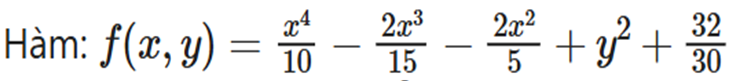

In [ ]:
# CHẠY THỬ – BÀI TOÁN MẪU GIỐNG ẢNH
def test_func(point: np.ndarray) -> float:
    x, y = point[0], point[1]
    return (x**4)/10 - (2*x**3)/15 - (2*x**2)/5 + y**2 + (32/30)

bounds = [(-5, 5), (-5, 5)]

# ABC gốc
result_abc = artificial_bee_colony(
    func=test_func,
    bounds=bounds,
    colony_size=40,
    max_cycles=500,
    limit=50,
    minimize=True,
    seed=42
)

# GABC
result_gabc = generalized_bee_colony(
    func=test_func,
    bounds=bounds,
    colony_size=40,
    max_cycles=500,
    limit=50,
    minimize=True,
    seed=42
)

# qABC
result_qabc = quantum_bee_colony(
    func=test_func,
    bounds=bounds,
    colony_size=40,
    max_cycles=500,
    limit=50,
    minimize=True,
    seed=42
)

def print_result(name: str, result: ABCResult, bounds):
    print(f"===== {name} =====")
    print("Kết quả xấp xỉ tốt nhất:", result.best_value)
    print("Vị trí [x, y] tốt nhất:", result.best_position)
    print("Số lần lặp:", result.n_evals)
    print("Với miền giá trị [x, y] là:", bounds)
    print("------------------------------------------\n")

print_result("ABC gốc", result_abc, bounds)
print_result("GABC", result_gabc, bounds)
print_result("qABC", result_qabc, bounds)



===== ABC gốc =====
Kết quả xấp xỉ tốt nhất: -2.220446049250313e-16
Vị trí [x, y] tốt nhất: [1.99999999e+00 5.87576395e-09]
Số lần lặp: 40238
Với miền giá trị [x, y] là: [(-5, 5), (-5, 5)]
------------------------------------------

===== GABC =====
Kết quả xấp xỉ tốt nhất: -2.220446049250313e-16
Vị trí [x, y] tốt nhất: [1.99999999e+00 5.08619424e-09]
Số lần lặp: 20120
Với miền giá trị [x, y] là: [(-5, 5), (-5, 5)]
------------------------------------------

===== qABC =====
Kết quả xấp xỉ tốt nhất: 1.6653345369377348e-14
Vị trí [x, y] tốt nhất: [ 1.99999999e+00 -1.29389180e-07]
Số lần lặp: 40657
Với miền giá trị [x, y] là: [(-5, 5), (-5, 5)]
------------------------------------------



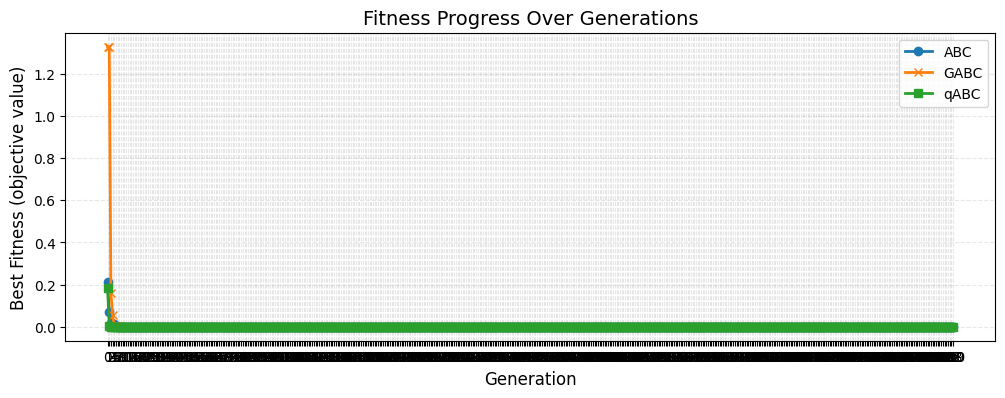

In [ ]:
# FITNESS PLOT – SO SÁNH ABC, GABC, qABC

plt.figure(figsize=(12, 4))

gen_abc  = list(range(len(result_abc.history_best)))
gen_gabc = list(range(len(result_gabc.history_best)))
gen_qabc = list(range(len(result_qabc.history_best)))

plt.plot(gen_abc,  result_abc.history_best,  marker='o', linewidth=2, label="ABC")
plt.plot(gen_gabc, result_gabc.history_best, marker='x', linewidth=2, label="GABC")
plt.plot(gen_qabc, result_qabc.history_best, marker='s', linewidth=2, label="qABC")

plt.title("Fitness Progress Over Generations", fontsize=14)
plt.xlabel("Generation", fontsize=12)
plt.ylabel("Best Fitness (objective value)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()

plt.xticks(gen_abc)

plt.show()


# Triển khai ABC tối ưu cho bài toán JCAS multibeam

Hàm mục tiêu theo báo:
image.png

In [ ]:
import matplotlib.pyplot as plt

# Xây dựng các thành phần:

# Vector steering - tạo vector đáp ứng hướng a của mảng ăng ten ULA
def steering_vector(theta, N, d=0.5, lam=1.0):
    """
    ULA steering vector a(theta) (Nx1), normalized by 1/sqrt(N).
    theta: radians
    d/lam: usually 0.5 for d = lam/2
    """
    n = np.arange(N)
    phase = 2 * np.pi * (d/lam) * n * np.sin(theta)
    a = np.exp(1j * phase) / np.sqrt(N)
    return a

# Xây dựng ma trận A
def build_A(theta_grid, N, d=0.5, lam=1.0):
    A = np.vstack([steering_vector(th, N, d, lam) for th in theta_grid])  # (M,N)
    return A

# Chuyển pha anten thành vector để thực hiện beamforming -> w
def w_from_phi(phi):
    """Analog beamforming vector w(phi) with constant magnitude 1/sqrt(N)."""
    N = len(phi)
    return np.exp(1j * phi) / np.sqrt(N)




# Hàm mục tiêu theo bài báo:

# Tính hệ số scale phức tối ưu cs
def compute_cs(A, D, v, w):
    """
    c_s for min || D (c_s A w_eff - v) ||^2
    using AF vector: y = A @ conj(w) (size M)
    """
    y = A @ np.conj(w)  # (M,)
    Dy = D * y
    Dv = D * v
    denom = np.vdot(Dy, Dy).real  # ||Dy||^2
    if denom < 1e-15:
        return 0.0 + 0.0j
    cs = np.vdot(Dy, Dv) / denom  # (Dy)^H (Dv) / ||Dy||^2
    return cs


# Đánh giá beampattern tạo ra từ pha này có giống beampattern mong muốn hay ko ?
def objective_J(phi, A, D, v, quantize_bits=None):
    """
    J(phi) = || D (c_s * y - v) ||^2
    where y = A @ conj(w(phi)).
    Optional phase quantization to b bits.
    """
    phi_use = np.array(phi, dtype=float)
    if quantize_bits is not None:
        L = 2**quantize_bits
        step = 2*np.pi / L
        phi_use = np.round(phi_use / step) * step
        phi_use = np.mod(phi_use, 2*np.pi)

    w = w_from_phi(phi_use)
    y = A @ np.conj(w)
    cs = compute_cs(A, D, v, w)
    err = (cs * y - v)
    return float(np.vdot(D*err, D*err).real)  # squared l2 norm



# Thuat toan ABC
def abc_optimize(
    obj_fn,
    dim,
    bounds,
    SN=30,              # food sources
    max_iter=200,
    limit=50,
    seed=0
):
    """
    Basic Artificial Bee Colony for minimization.
    bounds: list of (low, high) per dimension
    """
    rng = np.random.default_rng(seed)
    low = np.array([b[0] for b in bounds], dtype=float)
    high = np.array([b[1] for b in bounds], dtype=float)

    def clip_wrap(x):
        # wrap angles into [0,2pi) if that's your bounds; otherwise clip
        # here we assume bounds are [0, 2pi)
        x = np.mod(x - low, (high - low)) + low
        return x

    # init population
    X = rng.uniform(low, high, size=(SN, dim))
    f = np.array([obj_fn(x) for x in X], dtype=float)
    trial = np.zeros(SN, dtype=int)

    def fitness_from_cost(cost):
        # standard ABC fitness for minimization
        return 1.0 / (1.0 + cost)

    for it in range(max_iter):
        # --- Employed bees
        for i in range(SN):
            k = rng.integers(0, SN-1)
            if k >= i: k += 1
            j = rng.integers(0, dim)
            phi = rng.uniform(-1.0, 1.0)

            V = X[i].copy()
            V[j] = X[i, j] + phi * (X[i, j] - X[k, j])
            V = clip_wrap(V)

            fv = obj_fn(V)
            if fv < f[i]:
                X[i], f[i] = V, fv
                trial[i] = 0
            else:
                trial[i] += 1

        # --- Onlooker bees
        fit = np.array([fitness_from_cost(ci) for ci in f], dtype=float)
        probs = fit / (fit.sum() + 1e-12)

        n_onlookers = SN
        for _ in range(n_onlookers):
            i = rng.choice(SN, p=probs)
            k = rng.integers(0, SN-1)
            if k >= i: k += 1
            j = rng.integers(0, dim)
            phi = rng.uniform(-1.0, 1.0)

            V = X[i].copy()
            V[j] = X[i, j] + phi * (X[i, j] - X[k, j])
            V = clip_wrap(V)

            fv = obj_fn(V)
            if fv < f[i]:
                X[i], f[i] = V, fv
                trial[i] = 0
            else:
                trial[i] += 1

        # --- Scout bees
        for i in range(SN):
            if trial[i] > limit:
                X[i] = rng.uniform(low, high, size=(dim,))
                f[i] = obj_fn(X[i])
                trial[i] = 0

        best_idx = int(np.argmin(f))
        best_cost = float(f[best_idx])
        # print progress (optional)
        # print(f"Iter {it+1}/{max_iter}  best J = {best_cost:.6e}")

    best_idx = int(np.argmin(f))
    return X[best_idx].copy(), float(f[best_idx])


def build_multibeam_target(theta_grid, theta_c, theta_s, main_bw_deg=6.0,
                           v_comm=1.0+0j, v_sense=1.0+0j,
                           w_main=10.0, w_side=1.0):
    """
    Create desired AF vector v (complex) and weights D (real) over angle grid.
    - v is desired array factor amplitude (not power).
    - D is diagonal weights stored as vector (element-wise multiply).
    """
    main_bw = np.deg2rad(main_bw_deg)
    v = np.zeros(len(theta_grid), dtype=np.complex128)
    D = np.ones(len(theta_grid), dtype=float) * w_side

    # "main regions" around theta_c and theta_s
    mask_c = np.abs(theta_grid - theta_c) <= main_bw/2
    mask_s = np.abs(theta_grid - theta_s) <= main_bw/2

    v[mask_c] = v_comm
    v[mask_s] = v_sense
    D[mask_c] = w_main
    D[mask_s] = w_main
    return v, D

# Chạy thử

### Thiết lập tham số hệ thống:

In [ ]:
# số anten
N = 16
# d = λ/2
d = 0.5
lam = 1.0

# lưới góc
theta_grid = np.deg2rad(np.linspace(-60, 60, 721))

# hướng truyền thông (boresight)
theta_c = np.deg2rad(0.0)

# hướng sensing
theta_s = np.deg2rad(30.0)

### Xây dựng ma trận A

In [ ]:
A = build_A(theta_grid, N, d=d, lam=lam)

### Xây dựng beampattern

In [ ]:
v, D = build_multibeam_target(
    theta_grid,
    theta_c,
    theta_s,

    # độ rộng main lobe
    main_bw_deg=6.0,

    v_comm=1.0+0j,
    v_sense=1.0+0j,

    # ưu tiên main lobe
    w_main=20.0,

    # sidelobe
    w_side=1.0
)


### Định nghĩa hàm mục tiêu

In [ ]:
def J(phi):
    return objective_J(phi, A=A, D=D, v=v, quantize_bits=None)


### Chạy thuật toán abc

In [ ]:
bounds = [(0.0, 2*np.pi)] * N

best_phi, best_J = abc_optimize(
    obj_fn=J,
    dim=N,
    bounds=bounds,
    # số ong
    SN=40,

    # số vòng lặp
    max_iter=300,
    limit=80,
    seed=42
)

print("Best J =", best_J)


Best J = 1127.3447208609023


### Phân tích kết quả thu được

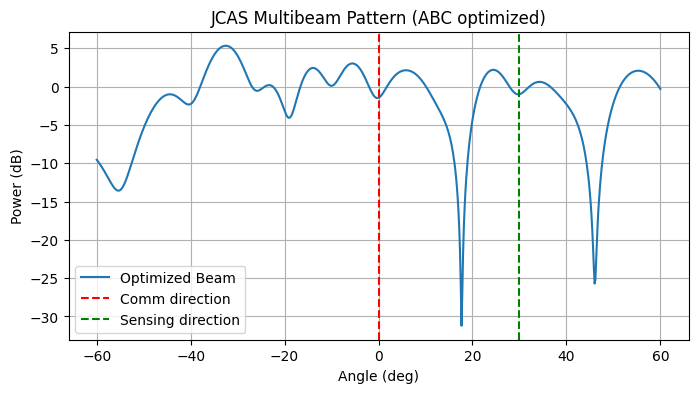

In [ ]:
# Tạo beamforming vector tối ưu
w_star = w_from_phi(best_phi)
cs_star = compute_cs(A, D, v, w_star)

# Tính beampattern kết quả
AF = A @ np.conj(w_star)
P = np.abs(cs_star * AF)**2


# Vẽ đồ thị
plt.figure(figsize=(8,4))
plt.plot(np.rad2deg(theta_grid), 10*np.log10(P + 1e-12), label="Optimized Beam")
plt.axvline(0, color='r', linestyle='--', label="Comm direction")
plt.axvline(30, color='g', linestyle='--', label="Sensing direction")
plt.xlabel("Angle (deg)")
plt.ylabel("Power (dB)")
plt.title("JCAS Multibeam Pattern (ABC optimized)")
plt.legend()
plt.grid(True)
plt.show()


# Tối ưu thuật toán theo bài báo

In [ ]:
def make_obj_paper_w_phase_only(A_KxN, v_K, d_weight_K):
    """
    Objective đúng paper:
        min_w  || D (cs*(A w*) - v) ||^2
    với cs được loại bằng nghiệm đóng:
        cs* = (Dy)^H(Dv) / (Dy)^H(Dy),  y = A w*
    ABC tối ưu phi (phase-only), w = exp(j phi).

    Inputs:
      A_KxN: (K, N) complex
      v_K:   (K,) complex
      d_weight_K: (K,) real >= 0  (D = diag(d_weight_K))
    """
    A_KxN = np.asarray(A_KxN, dtype=np.complex128)
    v = np.asarray(v_K, dtype=np.complex128).reshape(-1)
    d = np.asarray(d_weight_K, dtype=float).reshape(-1)

    K, N = A_KxN.shape
    if v.shape[0] != K:
        raise ValueError(f"v must have length K={K}, got {v.shape[0]}")
    if d.shape[0] != K:
        raise ValueError(f"d_weight must have length K={K}, got {d.shape[0]}")

    def obj(phi):
        phi = np.asarray(phi, dtype=float).reshape(-1)
        if phi.shape[0] != N:
            raise ValueError(f"phi must have length N={N}, got {phi.shape[0]}")

        # phi -> w (phase-only)
        w = np.exp(1j * phi)
        w = w / (np.linalg.norm(w) + 1e-12)   # enforce ||w||=1 (giống paper)
        w_conj = np.conjugate(w)              # w*

        # y = A w*
        y = A_KxN @ w_conj                    # (K,)

        # cs* closed-form
        Dy = d * y
        Dv = d * v
        cs = np.vdot(Dy, Dv) / (np.vdot(Dy, Dy) + 1e-12)

        # cost
        err = cs * y - v
        cost = np.sum((d * np.abs(err))**2)

        return float(np.real(cost))

    return obj, N


In [ ]:
# DEMO nếu bạn chưa có A, tạo tạm để test pipeline chạy
N = 16
K = 361
rng = np.random.default_rng(0)

A_KxN = rng.normal(size=(K, N)) + 1j*rng.normal(size=(K, N))  # (K,N) complex
v = np.zeros(K, dtype=np.complex128)
v[K//2] = 1.0 + 0j  # chỉ để test
d_weight = np.ones(K, dtype=float)


In [ ]:
obj, N2 = make_obj_paper_w_phase_only(A_KxN, v, d_weight)

bounds_phi = [(0.0, 2*np.pi)] * N2

result = artificial_bee_colony(
    func=obj,
    bounds=bounds_phi,
    colony_size=40,
    max_cycles=50,   # test nhanh
    limit=50,
    minimize=True,
    seed=42
)

phi_best = result.best_position
w_best = np.exp(1j*phi_best)
w_best = w_best / (np.linalg.norm(w_best) + 1e-12)

print("Best cost:", result.best_value)
print("w_best norm:", np.linalg.norm(w_best))


Best cost: 0.9592649519539035
w_best norm: 0.99999999999975
